In [1]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from enum import Enum

# Test Data

In [2]:
class TestData:
    def __init__(self, ticker, start,end):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.ge = None
        self.apple = None
        self.ultratech = None
        self.ms = None
        self.generateData()

    def generateData(self):
        df = web.DataReader(name=self.ticker, data_source="yahoo", start=self.start, end=self.end)
        df.to_csv("TestData.csv")
        df = pd.read_csv("TestData.csv", header=[0, 1], index_col=0, parse_dates=[0])
        self.ge = df.swaplevel(axis=1).GE.copy()
        self.ms = df.swaplevel(axis=1).MSFT.copy()
        self.apple = df.swaplevel(axis=1).AAPL.copy()
        data = df.swaplevel(axis=1)
        self.ultratech = data["ULTRACEMCO.NS"].copy()

### Enum for SMA or EMA

In [3]:
class MovingAverages(str,Enum):
    SMA = "Simple Moving Average"
    EMA = "Exponential Moving Average"

###  Model Class

In [4]:
class MAdata:
    def __init__(self, stockData, ticker, movingAverage=MovingAverages.SMA,shortPeriod=20, longPeriod=50):
        self.stockData = stockData
        self.ticker = ticker
        self.movingAverage = movingAverage
        self.shortPeriod = shortPeriod
        self.longPeriod = longPeriod

### Moving Average Crossover class

In [5]:
class MACrossover:
    def __init__(self,data):
        self.data = data
        self.shortWindow = str(data.shortPeriod) + '_' + data.movingAverage
        self.longWindow = str(data.longPeriod) + '_' + data.movingAverage


    def MovingAverageCrossStrategy(self):

        if self.data.movingAverage == MovingAverages.SMA:
            self.data.stockData[self.shortWindow] = self.data.stockData['Close'].rolling(window=self.data.shortPeriod, min_periods=1).mean()
            self.data.stockData[self.longWindow] = self.data.stockData['Close'].rolling(window=self.data.longPeriod, min_periods=1).mean()

        elif self.data.movingAverage == MovingAverages.EMA:
            self.data.stockData[self.shortWindow] = self.data.stockData['Close'].ewm(span=self.data.shortPeriod, adjust=False).mean()
            self.data.stockData[self.longWindow] = self.data.stockData['Close'].ewm(span=self.data.longPeriod, adjust=False).mean()

        self.data.stockData['Signal'] = 0.0
        self.data.stockData['Signal'] = np.where(self.data.stockData[self.shortWindow] > self.data.stockData[self.longWindow], 1.0, 0.0)
        self.data.stockData['Position'] = self.data.stockData['Signal'].diff()



    def MACrossoverGraph(self):
        plt.figure(figsize=(20, 10))
        plt.tick_params(axis='both', labelsize=14)
        self.data.stockData['Close'].plot(color='k', lw=1, label='Close Price')
        self.data.stockData[self.shortWindow].plot(color='b', lw=1, label=self.shortWindow)
        self.data.stockData[self.longWindow].plot(color='g', lw=1, label=self.longWindow)

        plt.plot(self.data.stockData[self.data.stockData['Position'] == 1].index,
                 self.data.stockData[self.shortWindow][self.data.stockData['Position'] == 1],
                 '^', markersize=15, color='g', alpha=0.7, label='buy')

        plt.plot(self.data.stockData[self.data.stockData['Position'] == -1].index,
                 self.data.stockData[self.shortWindow][self.data.stockData['Position'] == -1],
                 'v', markersize=15, color='r', alpha=0.7, label='sell')
        plt.ylabel('Price in ₹', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.title(str(self.data.ticker) + ' - ' + str(self.data.movingAverage) + ' Crossover', fontsize=20)
        plt.legend()
        plt.grid()
        plt.show()


    def MACrossoverTable(self,column = []):
        dataPostion =  self.data.stockData[( self.data.stockData['Position'] == 1) | ( self.data.stockData['Position'] == -1)]
        dataPostion['Position'] = dataPostion['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        if not column:
            print(tabulate(dataPostion, headers='keys', tablefmt='psql'))
        else:
            print(tabulate(dataPostion[column], headers='keys', tablefmt='psql'))

## Testing

In [14]:
column = ["Close","Signal","Position","20_Simple Moving Average","50_Simple Moving Average"]
ticker = ["MSFT","GE","AAPL","ULTRACEMCO.NS"]
start = "01-01-2018"
end = "31-12-2020"
data = TestData(ticker, start,end)




In [15]:
ge = MAdata(data.ge, ticker[1])

In [16]:
geCrossover = MACrossover(ge)

In [17]:
geCrossover.MovingAverageCrossStrategy()

In [18]:
geCrossover.MACrossoverTable(column)

+---------------------+----------+----------+------------+----------------------------+----------------------------+
| Date                |    Close |   Signal | Position   |   20_Simple Moving Average |   50_Simple Moving Average |
|---------------------+----------+----------+------------+----------------------------+----------------------------|
| 2018-05-07 00:00:00 | 13.5288  |        1 | Buy        |                   13.3851  |                   13.3781  |
| 2018-06-15 00:00:00 | 12.7885  |        0 | Sell       |                   13.5698  |                   13.5795  |
| 2018-10-24 00:00:00 | 11.7019  |        1 | Buy        |                   12.0024  |                   11.9923  |
| 2018-10-30 00:00:00 |  9.78846 |        0 | Sell       |                   11.8683  |                   11.8925  |
| 2019-01-14 00:00:00 |  8.55769 |        1 | Buy        |                    7.60425 |                    7.57304 |
| 2019-04-11 00:00:00 |  9.12    |        0 | Sell       |      

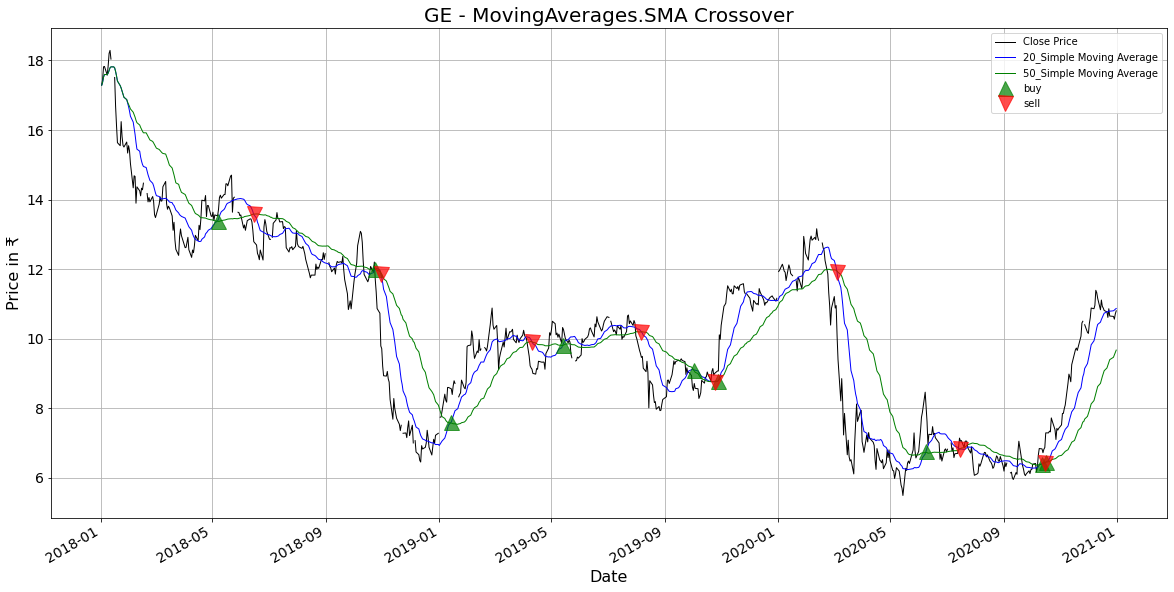

In [11]:
geCrossover.MACrossoverGraph()